<h1>Notebook aggiunto successivamente per analizzare l'errore non più rispetto alle label normalizzate ma rispetto a quelle originali (rescaled)</h1>

In [1]:
#encoding
from paper_code.parsing import get_datasets
from paper_code.encoding import Object2ObjectGraph, Object2AtomGraph, Atom2AtomGraph, ObjectPair2ObjectPairGraph
from paper_code.modelsTorch import get_compatible_model, get_tensor_dataset

#PyG
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GENConv, GINEConv, GATv2Conv, global_add_pool, global_mean_pool, global_max_pool

#torch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

#other
import os
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import optuna
from utils import extract_labels_from_samples, normalize_between_zero_and_one, check_edge_features_dim, add_zeros_edge_attributes, train_model, evaluate_model
from optuna_objectives import objective_GINEModel, objective_GENModel, objective_GAT
from models_architectures import GATModel, GENModel, GINEModel
from params import *

/usr/local/lib/python3.10/dist-packages/neuralogic/core/builder/builder.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
domains = ["blocks"]

In [ ]:
for domain in domains:
    print(f"STARTING DOMAIN {domain}")
    domain_folder = domain_folder_root + domain + "/"
    predictions_folder = "./predictions/" + domain.upper() + "/"
    instances = get_datasets(domain_folder, descending=False)
    for encoding in encodings_list:
        print(f"STARTING ENCODING {encoding}")
        #PREPROCESSING
        data_list = []
        for instance in instances:
            samples = instance.get_samples(eval(encoding))
            labels = extract_labels_from_samples(samples)
            norm_labels = normalize_between_zero_and_one(labels)
            #covert samples to PyG data format
            tensor_dataset = get_tensor_dataset(samples)
            #if there are no edge_attr add zeros edge_attributes in order to not have errors during training.
            # !!! N.B. !!! valutare di rimuovere questi pochi stati senza edge_Attr
            num_edge_features = check_edge_features_dim(tensor_dataset)

            # add zeros edge attributes if there are no edges
            tensor_dataset = add_zeros_edge_attributes(tensor_dataset, num_edge_features)

            #add_custom label and min/max value of the label in order to be able to transform prediction to original label
            min_label = np.min(labels)
            max_label = np.max(labels)
            for i, data in enumerate(tensor_dataset):
                custom_label = norm_labels[i]
                data.custom_label = custom_label
                data.min_label = min_label
                data.max_label = max_label
                data.instance_name = instance.name
            data_list.extend(tensor_dataset)


        #CHECK PREPROCESSING CORRECTNESS
        features = data_list[0].num_features
        process_correct = True
        for data in data_list:
            if data.num_features != features:
                print(f"Different number of features! --> {data.num_features}")
                process_correct = False
                raise Exception("Edge features with different dimension!")

        #TRAIN TEST SPLIT
        train_list, test_list = train_test_split(data_list, random_state=seed, test_size=0.1)

        #TEST
        # creating a df to store predictions
        list_df = []
        for item in test_list:
            list_df.append({"item":item,
                            "Label":item.custom_label.item()})
        df = pd.DataFrame(list_df)

        #test
        for model_type in ["GATModel","GENModel","GINEModel"]:
            print(f"--> Starting {model_type} test")
            torch.manual_seed(seed)
            #load study and best trial
            optuna_file = f"./optuna/{encoding}/{domain.upper()}/{model_type}_study.pkl"
            study = joblib.load(optuna_file)
            best_trial = study.best_trial
            #get loaders
            train_loader = DataLoader(train_list, batch_size=best_trial.params["batch_size"], shuffle=True)
            test_loader = DataLoader(test_list, batch_size=best_trial.params["batch_size"], shuffle=True)

            node_in_dim = train_loader.dataset[0].num_node_features
            num_edge_features = train_loader.dataset[0].num_edge_features
            output_dim = 1   

            if model_type == "GINEModel":
                model = GINEModel(node_in_dim=node_in_dim,
                                 hidden_dim=best_trial.params["hidden_dim"],
                                 output_dim=output_dim,
                                 fc_hidden_dim= best_trial.params["fc_hidden_dim"], 
                                 num_edge_features = num_edge_features, 
                                 readout=best_trial.params["readout"],
                                 dropout_rate=best_trial.params["dropout_rate"],
                                 training=False
                                 )
            if model_type == "GENModel":
                model = GENModel(node_in_dim=node_in_dim,
                                 hidden_dim=best_trial.params["hidden_dim"],
                                 output_dim=output_dim,
                                 fc_hidden_dim= best_trial.params["fc_hidden_dim"],
                                 hidden_layers=best_trial.params["hidden_layers"],
                                 aggregation_function=best_trial.params["aggregation_function"], 
                                 num_edge_features = num_edge_features, 
                                 readout=best_trial.params["readout"],
                                 dropout_rate=best_trial.params["dropout_rate"],
                                 training=False
                                 )
            if model_type == "GATModel":
                model = GATModel(node_in_dim=node_in_dim,
                                 hidden_dim=best_trial.params["hidden_dim"],
                                 output_dim=output_dim,
                                 fc_hidden_dim= best_trial.params["fc_hidden_dim"],
                                 num_edge_features=num_edge_features,
                                 dropout_rate=best_trial.params["dropout_rate"],
                                 readout=best_trial.params["readout"],
                                 hidden_layers=best_trial.params["hidden_layers"],
                                 activation_function=best_trial.params["activation_function"],
                                 heads=best_trial.params["heads"],
                                 training=False
                                 )
            optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params["lr"])
            criterion = nn.L1Loss()

            trained_model = train_model(model, train_loader, optimizer, criterion, epochs, verbose=0)
            mae = evaluate_model(trained_model, test_loader)

            # memorizzo le prediction
            predictions = []
            with torch.no_grad():
                for data in test_list:
                    out = trained_model(data)
                    predictions.append(out.item())
            df[model_type] = predictions
            print(f" Best trial had {best_trial.value} mean MAE on validation set \n the {model_type} model created with the best values have {mae} MAE on the test set")
            print("")

        #SAVE PREDICTIONS DF
        os.makedirs(predictions_folder, exist_ok=True)
        prediction_df = predictions_folder + f"{encoding}.csv"
        df.to_csv(prediction_df, sep=";", index=False)

STARTING DOMAIN blocks
STARTING ENCODING Object2ObjectGraph
--> Starting GATModel test


<h1>Rescaling delle predizioni per tornare alla scala originale</h1>

In [ ]:
#RESCALING PREDICTIONS
dict_results = {}
for domain in domains:
    print(f"STARTING DOMAIN {domain}")
    dict_results[domain] = {}
    domain_folder = domain_folder_root + domain + "/"
    predictions_folder = "./predictions/" + domain.upper() + "/"
    for encoding in encodings_list:
        df = pd.read_csv(predictions_folder + f"{encoding}.csv", sep=";")
        # GET ORIGINAL LABEL
        df["original_label"] = df["item"].apply(lambda x: eval(x).y)
        #GET INSTANCE NAME
        df["instance_name"] = df["item"].apply(lambda x: eval(x).instance_name)
        #RESCALING OF PREDICTIONS AND ROUND TO INT
        for model_type in ["GATModel", "GENModel", "GINEModel"]:
            new_column_name = model_type + "_rescaled"
            df[new_column_name] = df.apply(
                lambda x: x[model_type] * (eval(x["item"]).max_label - eval(x["item"]).min_label) + eval(x["item"]).min_label, axis=1
            )
            df[new_column_name] = df[new_column_name].round()
        os.makedirs(predictions_folder, exist_ok=True)
        prediction_df = predictions_folder + f"{encoding}_rescaled.csv"
        df.to_csv(prediction_df, sep=";", index=False)

STARTING DOMAIN blocks
STARTING DOMAIN logistics
STARTING DOMAIN rovers
STARTING DOMAIN sokoban


<h1>Calcolo del MAE con i valori rescaled (non i valroi tra 0 e 1)</h1>

In [ ]:
# Load results in a dict from csv
results = {}
for domain in domains:
    predictions_folder = "./predictions/" + domain.upper() + "/"
    results[domain] = {}
    for encoding in encodings_list:
        df = pd.read_csv(predictions_folder + f"{encoding}_rescaled.csv", sep=";")
        results[domain][encoding] = {}
        for model in ["GATModel","GENModel","GINEModel"]:
            MAE = mean_absolute_error(df["original_label"],df[model+"_rescaled"])
            MAE = np.round(MAE,3)
            results[domain][encoding][model] = MAE
results

{'blocks': {'Object2ObjectGraph': {'GATModel': 4.103,
   'GENModel': 3.372,
   'GINEModel': 2.774},
  'Object2AtomGraph': {'GATModel': 5.726,
   'GENModel': 3.085,
   'GINEModel': 3.548},
  'Atom2AtomGraph': {'GATModel': 3.857,
   'GENModel': 2.822,
   'GINEModel': 2.369}},
 'logistics': {'Object2ObjectGraph': {'GATModel': 7.305,
   'GENModel': 6.06,
   'GINEModel': 6.595},
  'Object2AtomGraph': {'GATModel': 7.34, 'GENModel': 5.785, 'GINEModel': 5.86},
  'Atom2AtomGraph': {'GATModel': 6.005,
   'GENModel': 5.905,
   'GINEModel': 5.665}},
 'rovers': {'Object2ObjectGraph': {'GATModel': 1.379,
   'GENModel': 1.165,
   'GINEModel': 0.863},
  'Object2AtomGraph': {'GATModel': 3.423,
   'GENModel': 2.133,
   'GINEModel': 1.492},
  'Atom2AtomGraph': {'GATModel': 1.024,
   'GENModel': 1.133,
   'GINEModel': 1.931}},
 'sokoban': {'Object2ObjectGraph': {'GATModel': 23.098,
   'GENModel': 23.766,
   'GINEModel': 23.246},
  'Object2AtomGraph': {'GATModel': 37.039,
   'GENModel': 22.739,
   'GINEMod

<h1>Plot MAE relativo ai valori rescaled</h1>

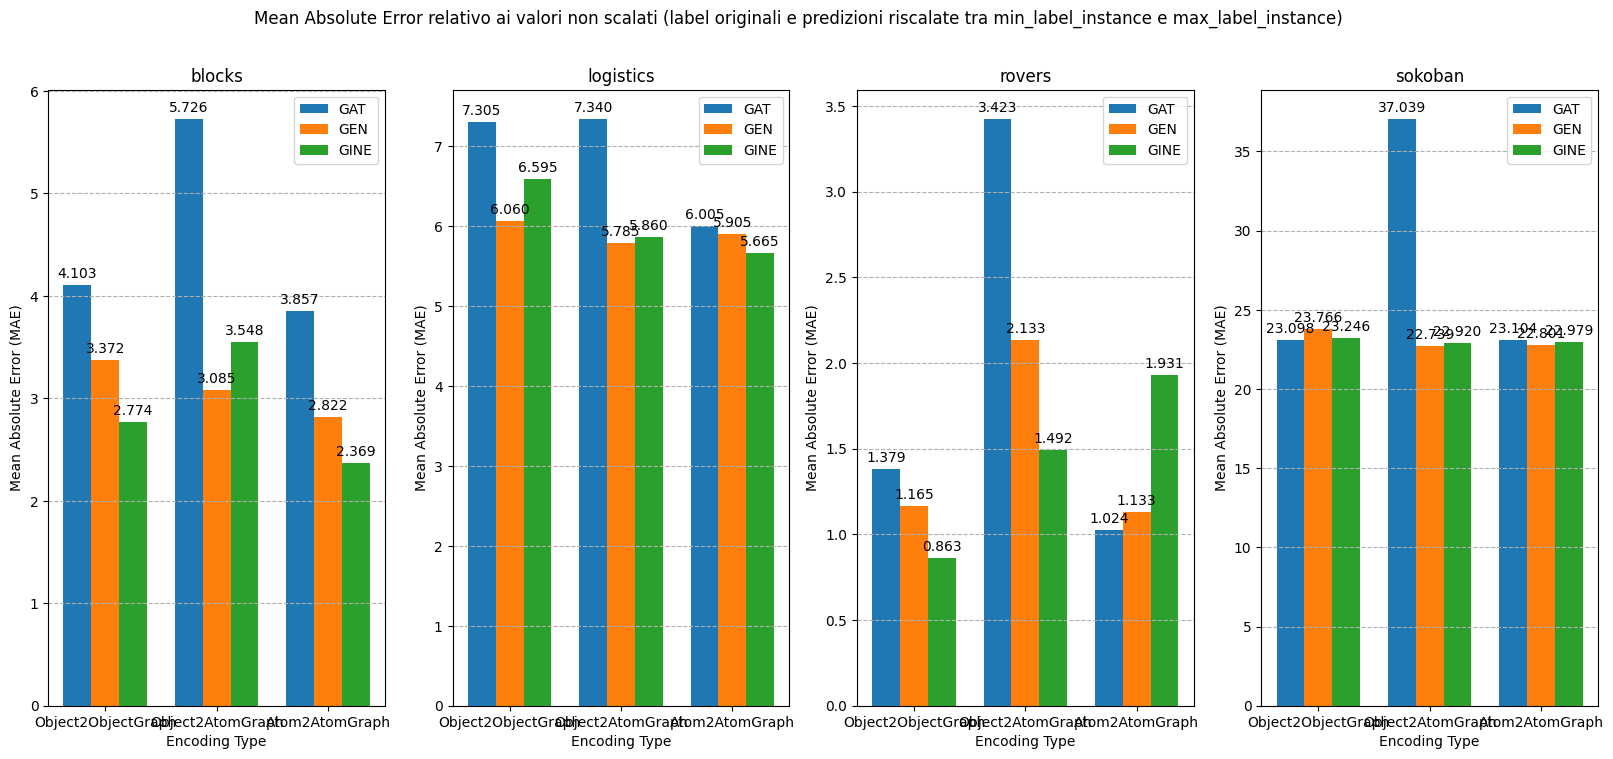

In [ ]:
fig, ax = plt.subplots(1,len(domains), figsize=(20,8))
for i,domain in enumerate(domains):
    labels = encodings_list
    predictions_GAT = []
    predictions_GEN = []
    predictions_GINE = []

    #populate predictions list
    for encoding in labels:
        predictions_GAT.append(results[domain][encoding]["GATModel"])
        predictions_GEN.append(results[domain][encoding]["GENModel"])
        predictions_GINE.append(results[domain][encoding]["GINEModel"])

    #plot
    x = np.arange(len(labels))
    width = 0.25
    bar1 = ax[i].bar(x-width, predictions_GAT, width, label="GAT")
    bar2 = ax[i].bar(x, predictions_GEN, width, label="GEN")
    bar3 = ax[i].bar(x+width, predictions_GINE, width, label="GINE")

    ax[i].set_xlabel("Encoding Type")
    ax[i].set_ylabel("Mean Absolute Error (MAE)")
    ax[i].set_title(domain)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    ax[i].grid(axis="y", linestyle="--")
    ax[i].legend()

    # Function to add the numerical values on top of the bars
    def autolabel(bars):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax[i].annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Apply autolabel to each set of bars
    autolabel(bar1)
    autolabel(bar2)
    autolabel(bar3)
plt.suptitle("Mean Absolute Error relativo ai valori non scalati (label originali e predizioni riscalate tra min_label_instance e max_label_instance)")
#save
plt.savefig(f"./results_analysis/encodings_and_models_comparison_resclaed.png")
plt.show()

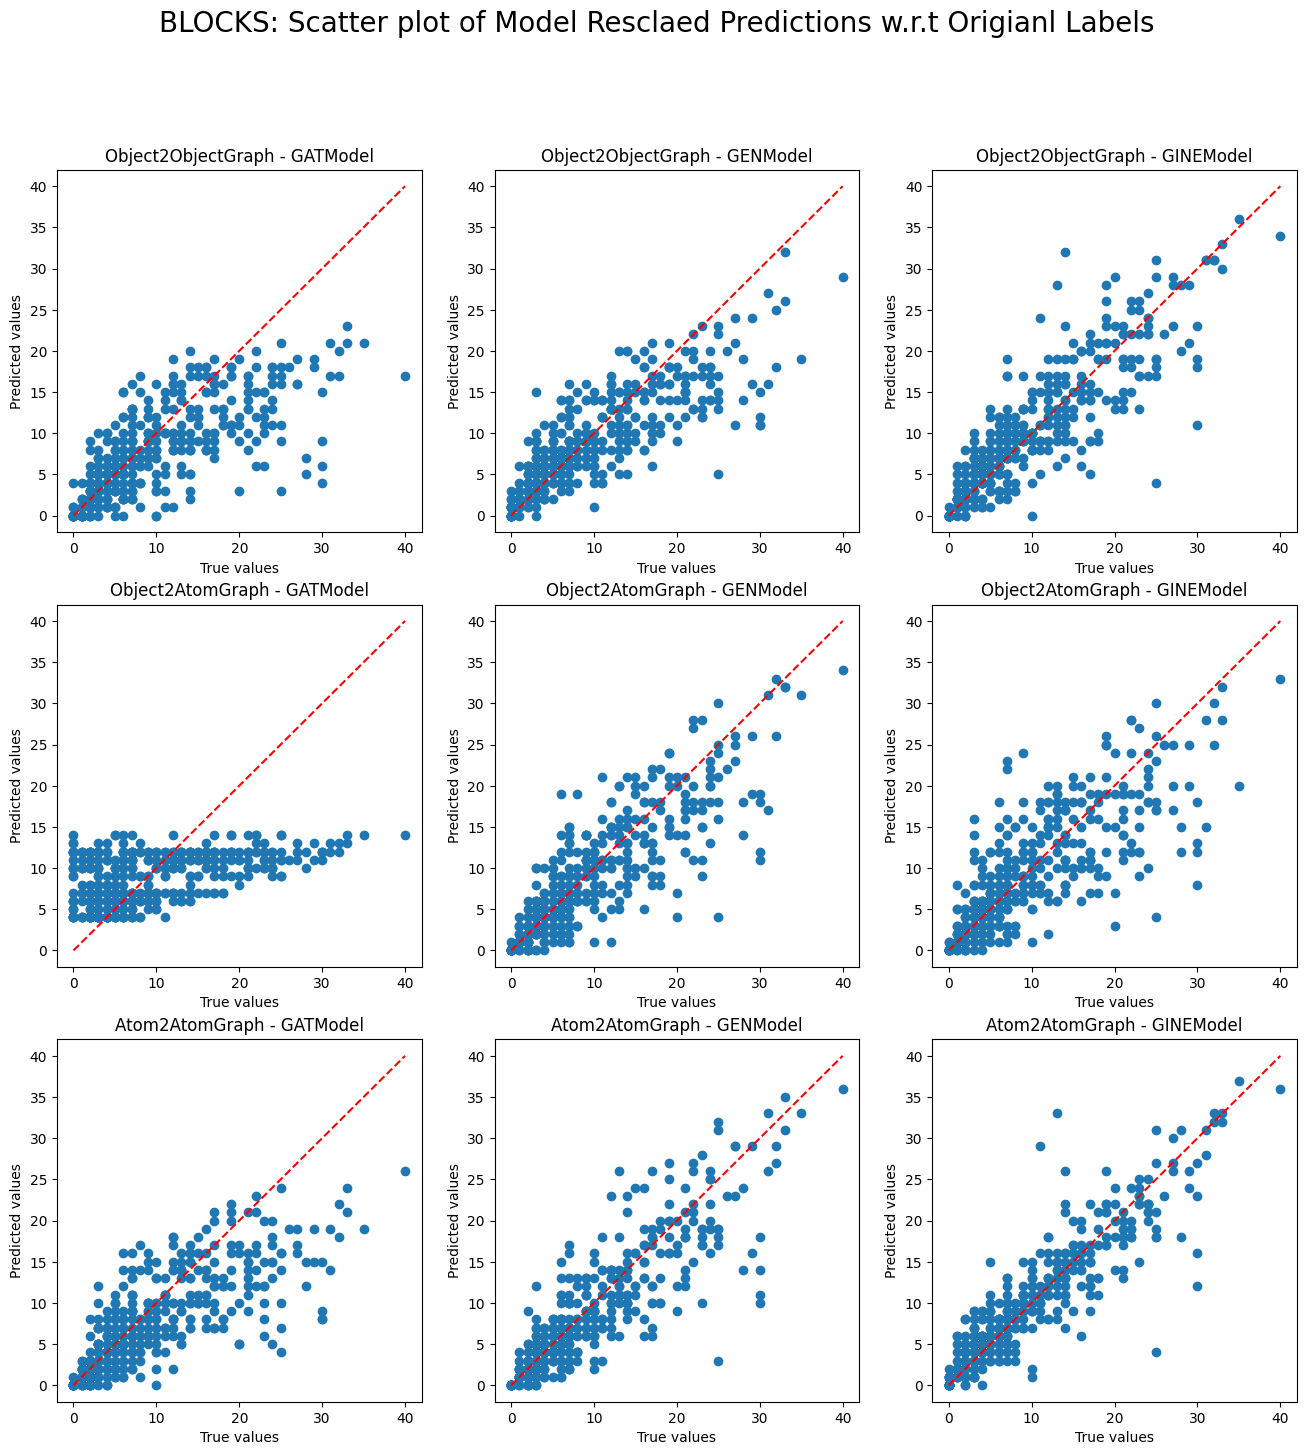

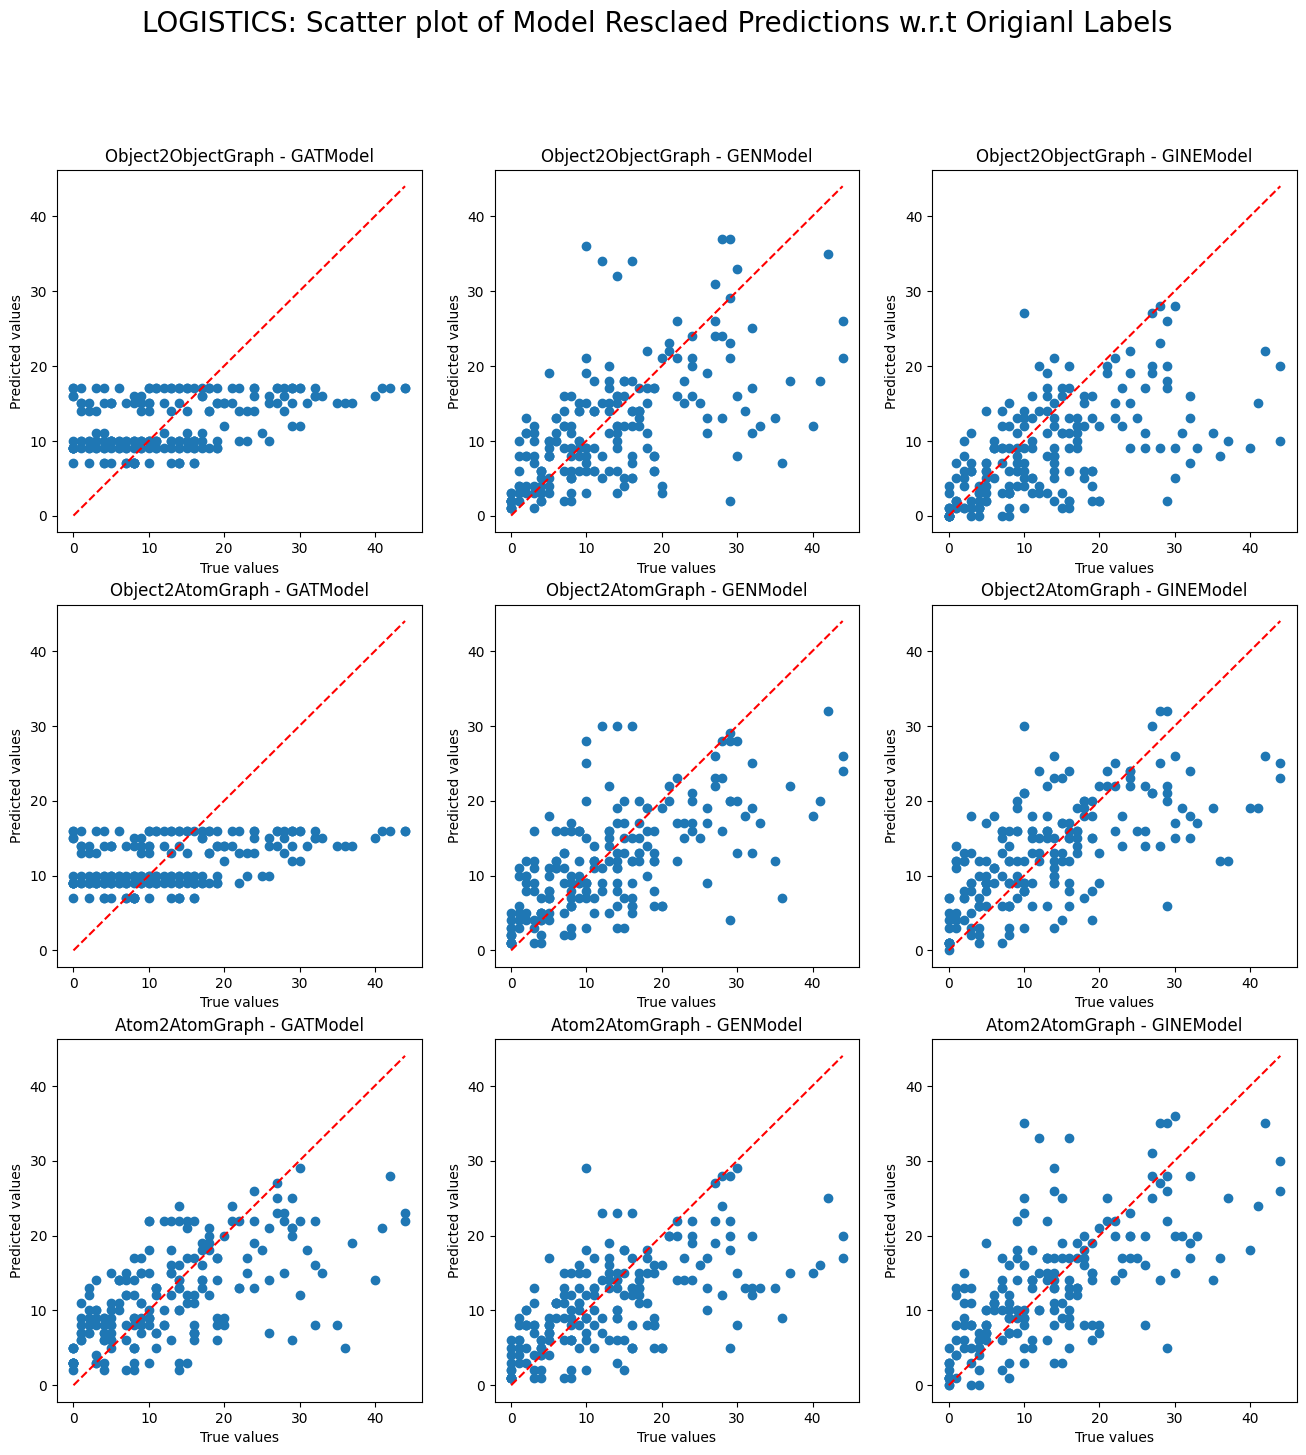

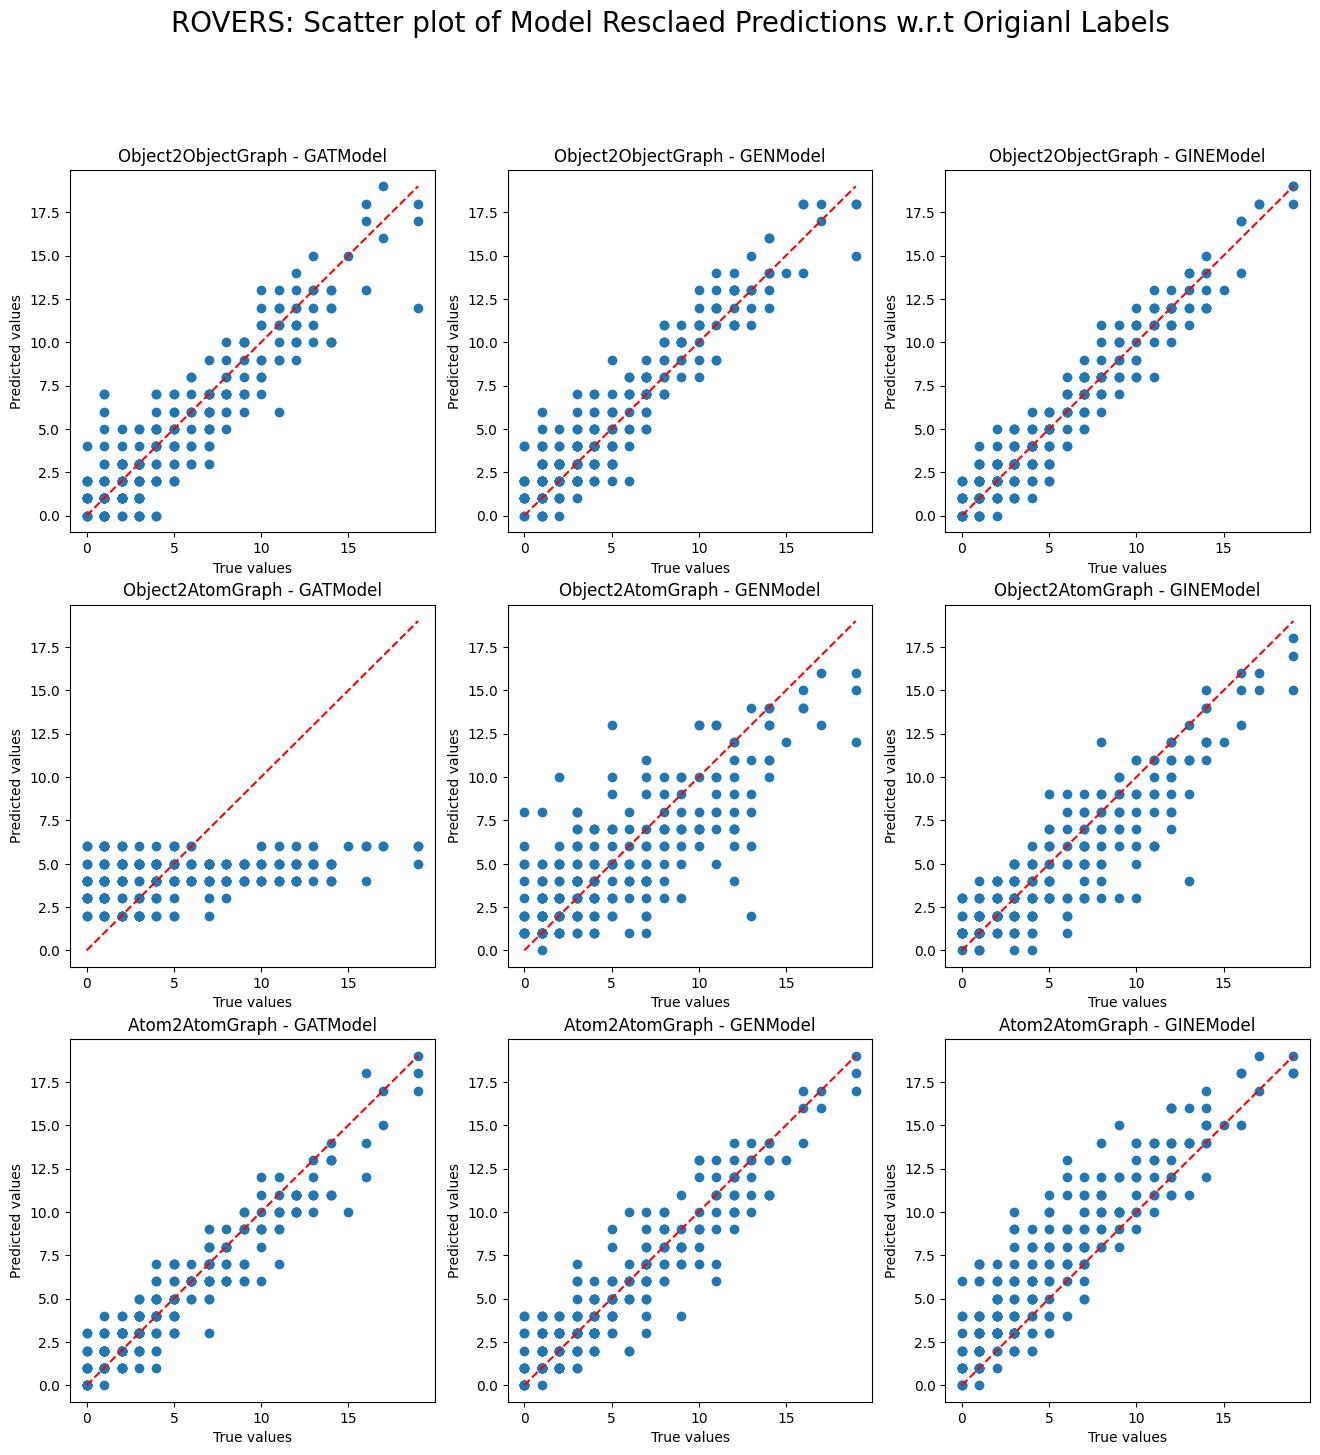

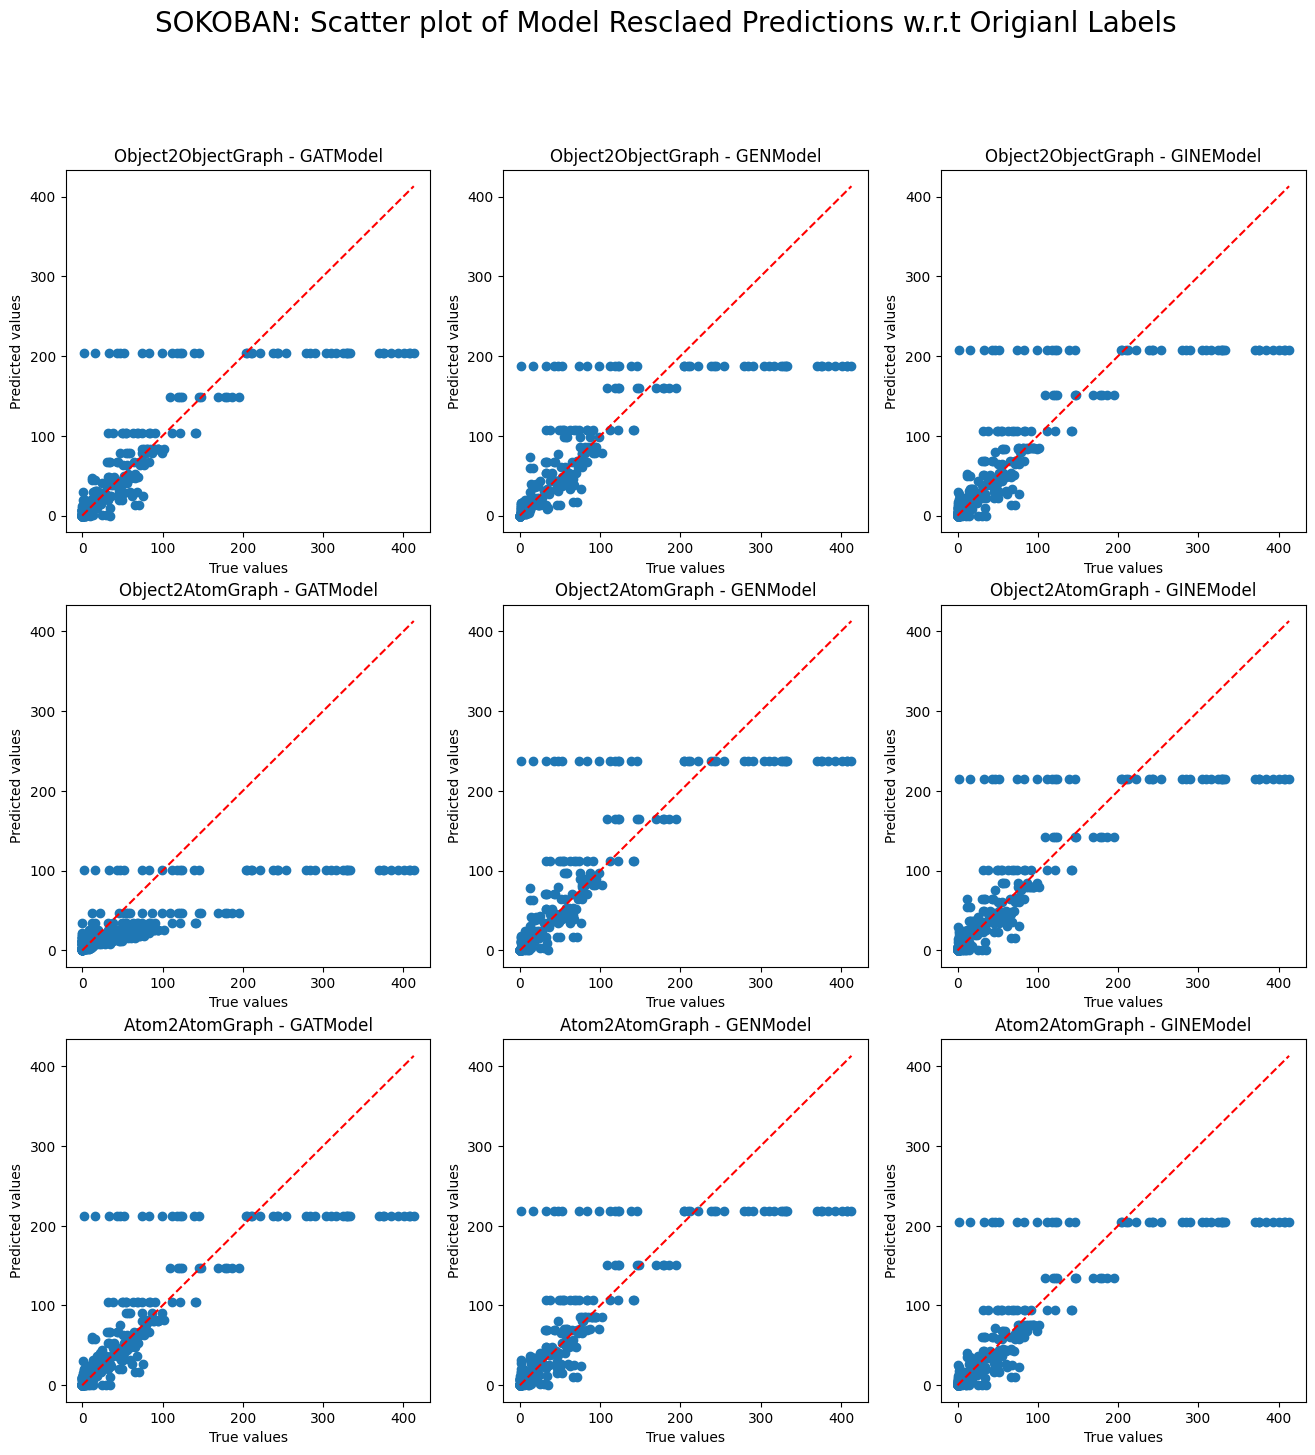

In [ ]:
for i,domain in enumerate(domains):
    predictions_folder = "./predictions/" + domain.upper() + "/"
    fig,ax= plt.subplots(3,3, figsize=(16,16))
    row = 0
    for encoding in encodings_list:
        df = pd.read_csv(predictions_folder + f"{encoding}_rescaled.csv", sep=";")
        for column, model in enumerate(["GATModel","GENModel","GINEModel"]):
            ax[row,column].scatter(df["original_label"],df[model+"_rescaled"])
            #ax[row,column].set_ylim(0,max(df["original_label"]))
            ax[row,column].plot([0, max(df["original_label"])], [0, max(df["original_label"])], color='red', linestyle='--')
            ax[row,column].set_title(f"{encoding} - {model}")
            ax[row,column].set_xlabel("True values")
            ax[row,column].set_ylabel("Predicted values")
        row += 1
    fig.suptitle(f"{domain.upper()}: Scatter plot of Model Resclaed Predictions w.r.t Origianl Labels", fontsize="20")
    plt.savefig(f"./results_analysis/{domain.upper()}/predictions_scatter_rescaled.png")
    plt.show()